https://www.cs.toronto.edu/~kriz/cifar.html


### Experiment 5:  Još CIFAR-10 podataka za trening

Postavlja se pitanje može li se rešiti problem nezadovoljavajućih performansi pomoću većeg skupa za treniranje.
- Fiksiramo odnos m/n = 0.6
- Povecavamo broj instanci unutar trening seta

In [0]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import pywt
import pickle

import numpy as np
import h5py
from matplotlib import pyplot as plt

from keras.layers import *
from keras.models import *
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import keras.backend as K

from sklearn.model_selection import train_test_split



### Ucitavanje CIFAR-10

In [0]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



imdata = None
for i in range(5):
    b = unpickle(''.join(['data_batch_', str(i+1)]))  
    imdata = b[b'data'] if imdata is None else np.vstack((imdata, b[b'data']))

print(imdata.shape)


(50000, 3072)


### Rad sa slikama, konverzija iz RGB u Gray i slicno

In [0]:
# Slika se u CIFAR 10 cuva na sledeci nacin:
# 10000 instanci x 3072 piksela
# 3072 piksela su [1024 crvena, 1024 zelena, 1024 plava]
# Dimenzija slike je 32x32x3 gde prvih 32 odg prvom redu

def convert_to_input_data(in_arr):
    y = np.zeros((in_arr.shape[0], 32, 32, 1))

    for i in range(in_arr.shape[0]):
        u = in_arr[i]
        u_tilda = rgb2gray(u)
        x0 = u_tilda
        y[i, :, :, :] = np.reshape(x0, (32, 32, 1))

    return y


# Konverzija RGB u sivu sliku
def rgb2gray(rgb):
    rgb = rgb.astype(float)/255.0
    im1 = rgb.reshape((3, 1024))
    r, g, b = im1[0], im1[1], im1[2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


# Haar transformacija nad sivom slikom
# https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html
def perform_Haar(u_tilda):
    u_tilda = np.reshape(u_tilda,(32, 32))
    c = pywt.wavedec2(u_tilda, 'haar', level=3)
    arr, slices = pywt.coeffs_to_array(c)
    x0 = arr
    return x0


# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html
def create_artificial_data():
    N = 1024
    x0 = np.random.choice([-1, 0, 1], size=1024, p=[0.05, 0.9, 0.05])
    x0 = np.reshape(x0, (32, 32))
    return x0


def create_A(shapeA):
    m, n = shapeA[0], shapeA[1]
    sigma2 = 1/m
    A = np.sqrt(sigma2) * np.random.randn(m, n)
    return A



### Pravljenje modela

In [0]:
def build_CNN_model(image_shape):
    print(image_shape)
    x_input = Input(image_shape)
    x = x_input
    
    for i in range(2):
        x = Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(0.01), padding='same')(x) 
        x = Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(0.01), padding='same')(x)
        x = BatchNormalization()(x) # Batch normalizacija unutrasnja normalizacija
        x = Activation('relu')(x)
        x = MaxPool2D((2,2))(x)

    x = Flatten()(x)  # razvlacenje da bismo imali adekvatan ulaz u mrezu sa propagacijom 
    x = Dense(1024, activation='linear', kernel_regularizer=l2(0.01))(x)
    x_kappa = Reshape((32, 32, 1))(x)
    
    model = Model(inputs=x_input, outputs=x_kappa, name = 'CNN')
#     model.summary()
    
    # Model ocekuje odgovarajuci ulaz i odgovarajuci izlaz, a na osnovu transformacija koje su koriscene da bi se 
    # od ulaza dobio odgovarajuci izlaz kreira medjuslojeve  
    return model


# https://keras.io/getting-started/sequential-model-guide/


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
  

def build_VAE(image_size):
    
    # network parameters
    original_dim = image_size*image_size
    input_shape = (original_dim,)
    latent_dim = 100
    
    # encoder model
    inputs = Input(shape=(image_size, image_size, 1), name='encoder_input')    
    x = Flatten()(inputs)  
    for i in range(2):
        x = Dense(400, kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    # generate latent vector Q(z|X)
    z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=l2(0.01))(x)
    z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=l2(0.01))(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    # decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for i in range(2):
        x = Dense(400, kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = Dense(original_dim, kernel_regularizer=l2(0.01))(x)   
    outputs = Reshape((image_size, image_size, 1))(x)
    decoder = Model(latent_inputs, outputs, name='decoder' )
    
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')    
#     vae.summary()
    
    return vae


  

### Funkcija greške i metrika za računanje tačnosti



In [0]:
def c_loss(y_true,y_pred):
    diff = (K.batch_flatten(y_true)-K.batch_flatten(y_pred))
    diff = K.pow(diff, 2)
    diff = K.abs(diff)
    norm2 = K.sum(diff, axis=(1))
    loss = K.mean(norm2)
    return loss


def metric_acc(y_true, y_pred):
    x_norm_2_pow_2 = (K.batch_flatten(y_true)-K.batch_flatten(y_pred))**2
    x_norm_2_pow_2 = K.sum(x_norm_2_pow_2, axis = -1)
    
    x0_norm_2_pow_2 = K.batch_flatten(y_true)**2
    x0_norm_2_pow_2 = 0.05*K.sum(x0_norm_2_pow_2, axis = -1)
    
    bool_tensor = K.cast(K.less_equal(x_norm_2_pow_2, x0_norm_2_pow_2), dtype='float32')
    acc = K.mean(bool_tensor)

    return acc       



### Experiment 5

In [0]:
in_shape = (32, 32, 1)

m_div_n = 0.6

N_train_list = [1500, 3000, 4000]

# cnn_res_exp5 = list()
# vae_res_exp5 = list()

for i in range(3):
    N_train, N_val, N_test = N_train_list[i], 1000, 1000
    print(N_train)
    x_train_val_arr, x_test_arr, y_train_val_arr, y_test_arr = train_test_split(imdata, imdata, 
                                                                              train_size = N_train+N_val, 
                                                                              test_size=N_test,
                                                                               random_state=42)
    x_train_arr, x_val_arr, y_train_arr, y_val_arr = train_test_split(x_train_val_arr, y_train_val_arr, 
                                                                      train_size = N_train, 
                                                                      test_size=N_val,
                                                                     random_state=42)

    y_train = convert_to_input_data(x_train_arr)
    y_val = convert_to_input_data(x_val_arr)
    y_test = convert_to_input_data(x_test_arr)
        
    m = int(m_div_n*n)
    print("New m_div_n, n={0}, m={1}".format(n, m))
    
    print("Create A")
    A = create_A((m, n))
   
    print("Prepare train/val/test sets")
    x_train = prepare_sets_exp1(y_train, A, False)
    x_val = prepare_sets_exp1(y_val, A, False)
    x_test = prepare_sets_exp1(y_test, A, False)
        
    cnn_model_exp5 = build_CNN_model(in_shape)
    cnn_model_exp5.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])
    
    print("Start trainig CNN")
    cnn_model_exp5.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=100, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=0),
                  ])
    res = cnn_model_exp5.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])
    print("Evaluacija CNN modela: {0}".format(res))
    cnn_res_exp5.append((N_train, res[1]))
    
    print("Build VEA model")
    vae_model_exp5 = build_VAE(in_shape[0])
    vae_model_exp5.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])

    print("Start trainig VAE")
    vae_model_exp5.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=250, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=0),
                  ])
    res = vae_model_exp5.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])

    print("Evaluacija VAE modela: {0}".format(res))
    vae_res_exp5.append((N_train, res[1]))


1500
New m_div_n, n=32, m=19
Create A
Prepare train/val/test sets
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 636us/step
Evaluacija CNN modela: [22.20379559326172, 0.465]
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 333us/step
Evaluacija VAE modela: [24.378545928955077, 0.336]
3000
New m_div_n, n=32, m=19
Create A
Prepare train/val/test sets
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 623us/step
Evaluacija CNN modela: [11.664651947021484, 0.77]
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 307us/step
Evaluacija VAE modela: [19.227892974853514, 0.477]
4000
New m_div_n, n=32, m=19
Create A
Prepare train/val/test sets
(32, 32, 1)
Start trainig CNN
1000/1000 [==============================] - 1s 664us/step
Evaluacija CNN modela: [11.047064491271973, 0.786]
Build VEA model
Start trainig VAE
1000/1000 [==============================] - 0s 361us/step
Eva

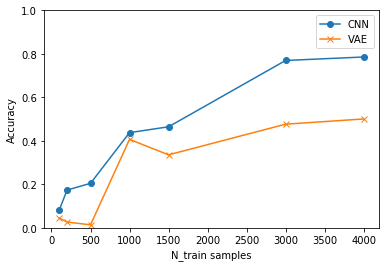

In [0]:
cnn_res_exp5_np = np.array(cnn_res_exp5)
vae_res_exp5_np = np.array(vae_res_exp5)

plt.figure()
plt.plot(cnn_res_exp5_np[:,0], cnn_res_exp5_np[:,1], '-o', label='CNN')
plt.plot(vae_res_exp5_np[:,0], vae_res_exp5_np[:,1], '-x', label='VAE')
plt.ylim([0, 1])
plt.xlabel("N_train samples")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 Zaista, povećanje obima skupa za treniranje počev od 2000 poboljšava performanse.Ipak, kad veličina trening skupa postane prevelika, tačnost modela počinje da stagnira.